# Identifying deforestation using CNNs

Using a variety of deep learning techniques, including transfer learning, to classify satellite images of the Amazon rainforest

## Preparing the data

We are given a folder with 40000+ satellite images and a corresponding csv file with the appropriate labels. In the following cell we will construct our dataframe, which consist of the appropriate labels and their respective file paths.

In [78]:
import numpy as np
from sklearn.datasets import load_files
from sklearn import preprocessing
from keras.utils import np_utils
from glob import glob
import pandas as pd
import re
from IPython.display import display

def load_data_files(path):
    data = load_files(path)
    filenames = np.array(data['filenames'])
    return filenames

def add_numerical(df):
    numerical = []
    for index, row in df.iterrows():
        numerical.append(re.sub("[^0-9]", "", row['filepath']))
        
    df['id'] = pd.Series(numerical).values
    return df
    
total_files = load_data_files('../data/train')
df = pd.DataFrame(np.hstack((total_files)))
df.columns = ['filepath']
df = add_numerical(df)
df['id'] = pd.to_numeric(df['id'], errors='coerce')
df = df.sort('id', ascending=True)
df.set_index('id', inplace=True)

csv_data = pd.read_csv('../data/labels.csv', na_filter=False)

df['image_name'] = pd.Series(csv_data['image_name'])
df['tags'] = pd.Series(csv_data['tags'])

display(df.head())

/Users/schumanzhang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


filepath image_name  \
id                                                   
0   ../data/train/train-jpg/train_0.jpg    train_0   
1   ../data/train/train-jpg/train_1.jpg    train_1   
2   ../data/train/train-jpg/train_2.jpg    train_2   
3   ../data/train/train-jpg/train_3.jpg    train_3   
4   ../data/train/train-jpg/train_4.jpg    train_4   

                                         tags  
id                                             
0                                haze primary  
1             agriculture clear primary water  
2                               clear primary  
3                               clear primary  
4   agriculture clear habitation primary road

After forming our dataframe, we will one-hot encode the labels. 


In [101]:
total_classes = ['agriculture', 'bare_ground', 'blooming', 'blow_down', 'clear',
    'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy',
    'primary', 'road', 'selective_logging', 'slash_burn', 'water', 'cloudy', 'artisinal_mine']

def constructLabelVector(dataFrame):
    result_vector = []
    for index, row in dataFrame.iterrows():
        pos = findPositionsWithinClasses(row['tags'])
        vector = createVector(pos)
        result_vector.append(vector)
    
    return result_vector
        
def findPositionsWithinClasses(string):
    positions = []
    list_strings = string.split()
    for word in list_strings:
        index = total_classes.index(word)
        positions.append(index)
        
    return positions
        
def createVector(pos):
    vector = []
    for i in range(len(total_classes)):
        if i in pos:
            vector.append(1)
        else:
            vector.append(0)
    
    return vector
            
targets = np.array(constructLabelVector(df))

print('There are %d labels in total.' % len(targets))

There are 40479 labels in total.


Splitting the data into training, validation and testing sets. This will consist of the filepaths and their respective multi-label vectors. We will split the total data in training and testing sets at a 80/20 ratio and then split the training data into training and validation sets at a 80/20 ratio.

In [117]:
total_files = np.array(df['filepath'])

print('There are %d images in total.' % len(total_files))

def splitFiles(files, targets):
    length = len(files)
    split_point = int(round(length * 0.8))
    return files[:split_point], targets[:split_point], files[split_point:], targets[split_point:]
    
train_valid_files, train_valid_targets, test_files, test_targets = splitFiles(total_files, targets)

train_files, train_targets, valid_files, valid_targets = splitFiles(train_valid_files, train_valid_targets)

print(len(train_files) + len(valid_files) + len(test_files))

print('There are %d training images in total.' % len(train_files))
print('There are %d validation images in total.' % len(valid_files))
print('There are %d testing images in total.' % len(test_files))



There are 40479 images in total.
40479
There are 25906 training images in total.
There are 6477 validation images in total.
There are 8096 testing images in total.


Showing some of the training images and their respective labels

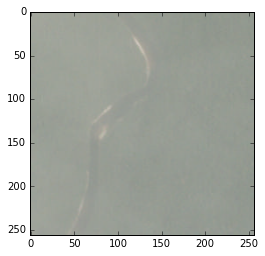

['haze', 'primary', 'water']


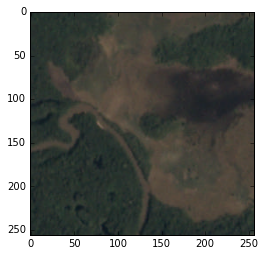

['agriculture', 'clear', 'primary', 'slash_burn', 'water']


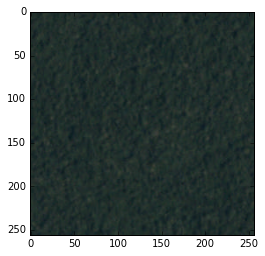

['clear', 'primary']


In [124]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline

def showImage(num_list):
    for num in num_list:
        img = cv2.imread(train_files[num])
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(cv_rgb)
        plt.show()
        print(convertBackToLabels(train_targets[num]))

def convertBackToLabels(array):
    tags = []
    list_values = array.tolist()
    for i in range(len(list_values)):
        if list_values[i] == 1:
            tags.append(total_classes[i])
    
    return tags
        
showImage([5, 10, 15])


## Building CNN from scratch

In this section we will build a CNN from scratch. We will try out a number of different parameters and architectures in order to maximize for accuracy and the F2 score. We will also compare our result with our benchmark model here.

Preprocessing image data and return 4D tensors for every image (Keras requires 4D array as input), then we will rescale the images before using them in our CNN.


In [125]:
from keras.preprocessing import image
from tqdm import tqdm

def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(256, 256))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

We rescale our images by dividing every pixel in every image by 255

In [ ]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 25906/25906 [04:45<00:00, 90.82it/s]
